In [1]:
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from torch.autograd import Variable

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [92]:
class Net(Module):
    def __init__(self, norm = False):
        self.l = LinBnDrop(10,1)
        self.eps = Variable(tensor(1e-7), requires_grad=False)
        self.m =   Variable(tensor(1e-7), requires_grad=False)
        self.s =   Variable(tensor(1e-7), requires_grad=False)
        self.norm = norm
        
    def forward(self, x):        
        if self.norm:
            self.m, self.s = torch.mean(x,-1,keepdim=True), x.std(-1,keepdim=True) + self.eps
            x = (x-self.m)/self.s
        res= self.l(x)
        if self.norm:
            return (x*self.s)+self.m
        return res
    
        

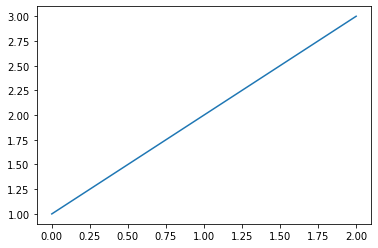

In [93]:
class tensorT(torch.Tensor):
    def show(self,ctx=None):
        if ctx is None:
            f, ctx = plt.subplots()
        ctx.plot(self)
        
a = tensorT([1,2,3])
a.show()

In [121]:
def make_data(rows = 100, norm = False):
    items = []
    for i in range(rows):        
        x = torch.arange(10) + torch.randn(10)
        bias = torch.randn(1)*100
        xy = (tensorT(bias+x).float(),tensorT( tensor([torch.sum(x) + bias])).float())
        if norm:
            m, s =torch.mean(xy[0], ), torch.std(xy[0],) + 1e-7
            xy = (tensorT((xy[0]-m)/s),tensorT((xy[1]-m)/s))
        items.append(xy)
    return items

In [122]:
for o in TfmdDL(make_data(rows = 1)):
    break
o[0].mean(), o[1].mean()

(tensor(-258.7474), tensor(-222.3776))

In [123]:
for o in TfmdDL(make_data(rows = 1, norm = True)):
    break
o[0].mean(), o[1].mean()

(tensor(4.8876e-07), tensor(16.1492))

(#4) [0,49.58485794067383,12.580252647399902,'00:00']
(#4) [1,24.795486450195312,3.389631509780884,'00:00']
(#4) [2,15.3867826461792,3.9178078174591064,'00:00']


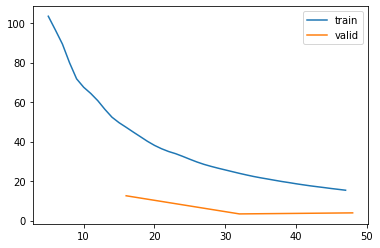

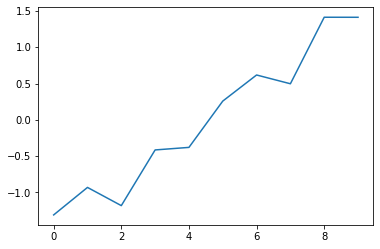

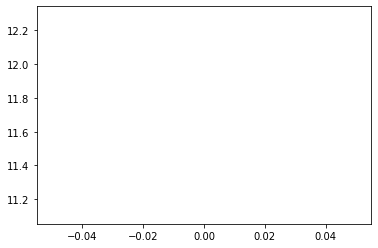

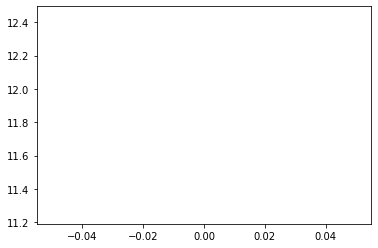

In [124]:
m = Net()
data = DataLoaders(*[TfmdDL(make_data(1000, norm = True)) for _ in range(2)])
learn = Learner(data, m, F.mse_loss)

learn.fit(3, .5)
learn.recorder.plot_loss()    
learn.show_results(max_n=1)

(#4) [0,3184.5615234375,463.8067321777344,'00:00']
(#4) [1,1958.7576904296875,287.7974853515625,'00:00']
(#4) [2,1319.5640869140625,17.81574821472168,'00:00']


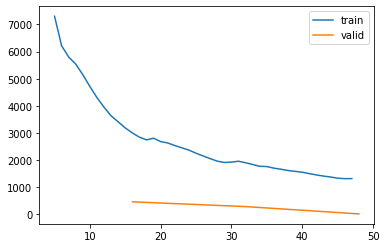

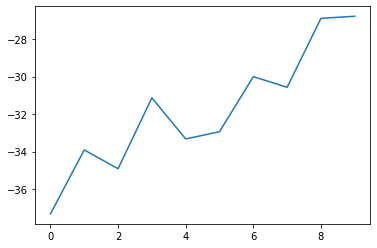

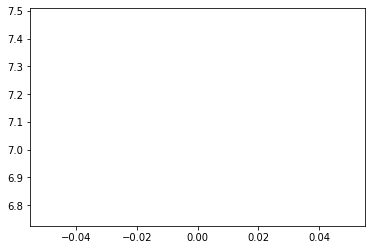

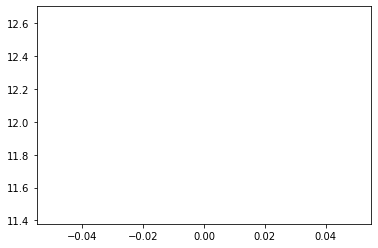

In [125]:
m = Net()
data = DataLoaders(*[TfmdDL(make_data(1000, norm = False)) for _ in range(2)])
learn = Learner(data, m, F.mse_loss)

learn.fit(3, .5)
learn.recorder.plot_loss()       
learn.show_results(max_n=1)

In [126]:
m = Net(norm = True)
data = DataLoaders(*[TfmdDL(make_data(norm = False)) for _ in range(2)])
learn = Learner(data, m, F.mse_loss)

learn.fit(3)
learn.recorder.plot_loss()         
learn.show_results(max_n=1)

(#3) [0,1712.11279296875,'00:00']


/home/tako/dev/env37/lib/python3.7/site-packages/fastai2/learner.py:256: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  self.loss = self.loss_func(self.pred, *self.yb); self('after_loss')


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

# Alternative

Other way with `ItemTransform` does give problems with `show_results`. This is because the batch size differs and the transform assums the same batch will first encoded and then decoded. Somewhere this asumtion is not met.

In [127]:
class NormalizeTS(ItemTransform):
    "Normalize the Time-Series."
    def __init__(self, verbose=False, make_ones=True, eps=1e-7, mean = None):
        """
        `make_ones` will make the std 1 if the std is smaller than `10*eps`. 
        This is for blok seqences to not magnify the `y` part of the data.
        
        `mean` will set a mean instead of the mean of the x value.
        """
        store_attr(self,'verbose, make_ones, eps, mean')
        self.m, self.s = 0, 0
        
    def encodes(self, o):         
        self.m, self.s = torch.mean(o[0],-1,keepdim=True), o[0].std(-1,keepdim=True) +self.eps
        if self.verbose:
            print('encodes',type(o),[a.shape for a in o], self.m,self.s) 
        if self.mean:
            self.m = o[0][self.mean]
        if self.make_ones:
            self.s[self.s < self.eps*10] = 1
            if self.verbose:
                print(o[0])
                print(f"made {self.s < self.eps*10} to ones due to setting `make_ones`")
                print(f"m:{self.m}\n s:{self.s}")
        return Tuple([(o[i]-self.m)/self.s for i in range(len(o))])
    
    def decodes(self, o): 
        if o[0].is_cuda:
            self.m, self.s = to_device(self.m,'cuda'), to_device(self.s,'cuda')
            if sum([a.is_cuda for a in o]) != len(o):
                o = Tuple([to_device(a,'cuda') for a in o])
        else:
            if sum([a.is_cuda==False for a in o]) != len(o):
                o = Tuple([to_cpu(a) for a in o])
            self.m, self.s = to_cpu(self.m), to_cpu(self.s)
        if self.verbose:
            print('decodes',type(o),[a.shape for a in o], 'shape m/s',self.m.shape)
        return Tuple([(o[i]*self.s)+self.m for i in range(len(o))])
        
        
        

(#4) [0,38.66653060913086,17.52260398864746,'00:00']
(#4) [1,19.301971435546875,2.8786635398864746,'00:00']
(#4) [2,12.273947715759277,2.997681140899658,'00:00']


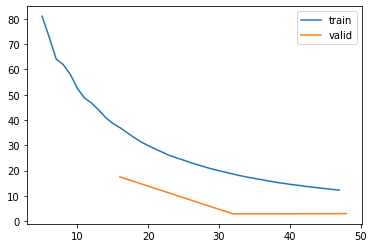

In [130]:
m = Net()
data = DataLoaders(*[TfmdDL(make_data(1000),after_batch=[NormalizeTS()]) for _ in range(2)])
learn = Learner(data, m, F.mse_loss)

learn.fit(3, .5)
learn.recorder.plot_loss()    

In [131]:
learn.show_results()

RuntimeError: The size of tensor a (64) must match the size of tensor b (40) at non-singleton dimension 0